## In this note book, we will learn how to compute the likelihood in lenstronomy.

In [16]:
import numpy as np
import os
import time
import corner
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
import lenstronomy.Util.util as util

- Set random seed and input the psf file

In [17]:
np.random.seed(41)

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


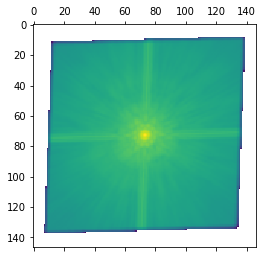

In [18]:
z_lens = 0.5
z_source = 1.5
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)


path = os.getcwd()
dirpath, _ = os.path.split(path)
module_path, _ = os.path.split(dirpath)
psf_filename = os.path.join(module_path, 'Users\ZN\Desktop\lenstronomy\psf_example.fits')# input the psf file
kernel = pyfits.getdata(psf_filename)

plt.matshow(np.log10(kernel))
plt.show()

- Firstly, we construct a data image.

In [23]:
# data specifics
background_rms = 0.9  #  background noise per pixel (Gaussian rms value)
exp_time = 80  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)

'''
↑ These two variables decide the variance of the gaussian noise and poisson noise. 
  Check image_util.add_poisson and image_util.add_bkg for more details.
'''

numPix = 120  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF (only valid when psf_type='gaussian')
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 91  # PSF kernel size (odd number required).

# initial input simulation
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
# generate the coordinate grid and image properties
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
'''
↑ Note that the 'exp_time' and 'background_rms' are now inputted and stored in the 'data_class'.
'''


# generate the psf variables
kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf = {'psf_type': psf_type, 'fwhm': fwhm, 'pixel_size': deltaPix, 'kernel_point_source': kernel_cut}
psf_class = PSF(**kwargs_psf)

# initial input simulation
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
# generate the coordinate grid and image properties
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
# generate the psf variables
kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf = {'psf_type': psf_type, 'fwhm': fwhm, 'pixel_size': deltaPix, 'kernel_point_source': kernel_cut}
psf_class = PSF(**kwargs_psf)


# lensing quantities
kwargs_shear = {'gamma1': 0.0, 'gamma2': -0.05}  # shear values to the source plane
kwargs_pemd = {'theta_E': 1.16, 'gamma': 1.95, 'center_x': 0.0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}  # parameters of the deflector lens model
kwargs_nfw = {'alpha_Rs': 0.02, 'Rs': 0.1, 'center_x': 1., 'center_y': 1}
# the lens model is a supperposition of an elliptical lens model with external shear
lens_model_list = ['EPL', 'SHEAR', 'NFW']
kwargs_lens = [kwargs_pemd, kwargs_shear, kwargs_nfw]
lens_model_class = LensModel(lens_model_list=lens_model_list)


# choice of source type
source_x = 0
source_y = 0

# Sersic parameters in the initial simulation
phi_G, q = 0.5, 0.8
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_source = {'amp': 4000, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': e1, 'e2': e2, 'center_x': source_x, 'center_y': source_y}
#kwargs_else = {'sourcePos_x': source_x, 'sourcePos_y': source_y, 'quasar_amp': 400., 'gamma1_foreground': 0.0, 'gamma2_foreground':-0.0}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic_source]
source_model_class = LightModel(light_model_list=source_model_list)

# lens light model
phi_G, q = 0.9, 0.9
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_lens = {'amp': 8000, 'R_sersic': 0.2, 'n_sersic': 2., 'e1': e1, 'e2': e2, 'center_x': 0.0, 'center_y': 0}
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [kwargs_sersic_lens]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                lens_light_model_class, kwargs_numerics=kwargs_numerics)
'''
↑ Set up the parameters for the data image.
'''

# generate image
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light)# update kwargs_data with the newly generated mock
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
image_sim = image_sim + bkg + poisson

kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)

'''
↑ 'image_sim' is the data image generated. Now it is stored in the 'data_class'. You can access this data by 'data_class.data'
'''


"\n↑ 'image_sim' is the data image generated. Now it is stored in the 'data_class'. You can access this data by 'data_class.data'\n"

- After running the above codes, we have generated a data image, which is saved in the 'data_class'. 
- We can now take a look at the data image, the data image without noises (i.e. a model generated by the above parameters), poisson noise and gaussian noise.

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


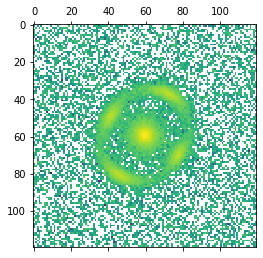

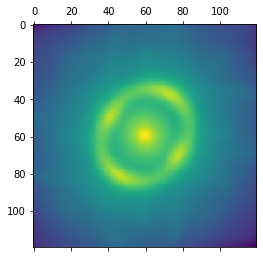

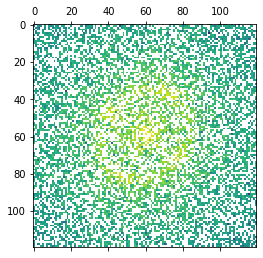

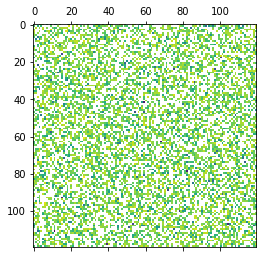

In [24]:
plt.matshow(np.log10(data_class.data))
t_model=data_class.data-poisson-bkg
plt.matshow(np.log10(t_model))
plt.matshow(np.log10(poisson))
plt.matshow(np.log10(bkg))

- Since 'data_class' stores the information of the data image, we can then use 'data_class.log_likelihood(model,mask=mask)' to get the likelihood between the data and a model we input in this function.

- Note that you must input a mask as well, checking imaging_data.py for more information of the mask variable.

In [25]:
# construct a trivial mask (all ones). 
mask=np.ones(np.shape(t_model))

# then we can calculate the likelihood between the data and the model. The data and model images are the ones we drew above.
data_class.log_likelihood(t_model,mask=mask)

-7231.515096506554

- Remember that log_likelihood is also the minus of one half of chi^2. Hence you can check that chi^2 is close to the number of pixels (which is 14400=120*120).

- Now we want to draw a likelihood function with respect to a varying parameter. Here I just vary the radius of the Einstein ring ('theta_E') for an example.

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in log10


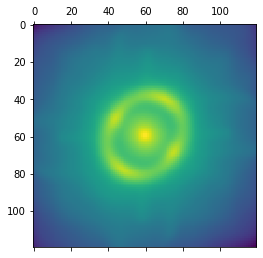

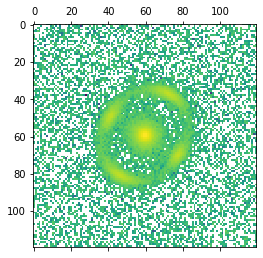

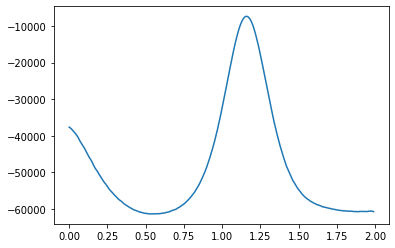

In [40]:
'''
Since we want to observe the different behaviors of the different types of the noises. 
We need to repeat some necessary parts of the previous codes to generate data image.
'''

'''
In this part, we keep both the gaussian noise and poisson noise.
'''

background_rms = 0.9    # the variance of gaussian noises
exp_time = 80           # determining the variance of poisson noises
numPix = 120 
deltaPix = 0.05
fwhm = 0.1  
psf_type = 'PIXEL' 
kernel_size = 91

kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf = {'psf_type': psf_type, 'fwhm': fwhm, 'pixel_size': deltaPix, 'kernel_point_source': kernel_cut}
psf_class = PSF(**kwargs_psf)
kwargs_pemd = {'theta_E': 1.16, 'gamma': 1.95, 'center_x': 0.0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}
kwargs_lens = [kwargs_pemd, kwargs_shear, kwargs_nfw]
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light)
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
image_sim = image_sim + bkg + poisson
kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)


ThetaE_t1=np.zeros(200)
LogLikelihood_t1=np.zeros(200)

for i in range(200):
    thetaE=0.01*i     
    # varying theta_E from 0.00 to 1.99. Each model image generated by a value of theta_E will give a log_likelihood value.
    # Note that you have to repeat several lines which are influced by the varying theta_E 
    kwargs_pemd = {'theta_E': thetaE, 'gamma': 1.95, 'center_x': 0.0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}
    kwargs_lens = [kwargs_pemd, kwargs_shear, kwargs_nfw]
    model_vary = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light)
    log_L=data_class.log_likelihood(model_vary,mask)
    if i==100: # this part aims to quickly display and check the model image at some specific value.
        plt.matshow(np.log10(model_vary))
        plt.matshow(np.log10(data_class.data))
        plt.show()
    ThetaE_t1[i]=thetaE
    LogLikelihood_t1[i]=log_L
    
plt.plot(ThetaE_t1,LogLikelihood_t1)

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log10


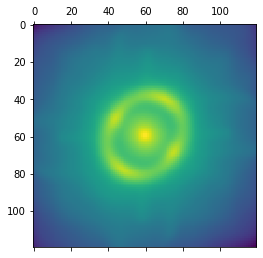

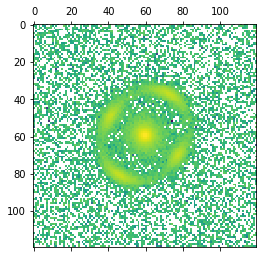

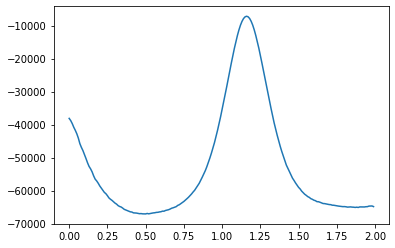

In [27]:
'''
In this part, we set the poisson noise to zero, keeping only the gaussian background.
'''
background_rms = 0.9
exp_time = np.inf    # Set the exp_time to infinity will make the variance of poisson noise to be zero.
numPix = 120 
deltaPix = 0.05
fwhm = 0.1  
psf_type = 'PIXEL' 
kernel_size = 91

kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf = {'psf_type': psf_type, 'fwhm': fwhm, 'pixel_size': deltaPix, 'kernel_point_source': kernel_cut}
psf_class = PSF(**kwargs_psf)
kwargs_pemd = {'theta_E': 1.16, 'gamma': 1.95, 'center_x': 0.0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}
kwargs_lens = [kwargs_pemd, kwargs_shear, kwargs_nfw]
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light)
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
image_sim = image_sim + bkg + poisson
kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)



ThetaE_t2=np.zeros(200)
LogLikelihood_t2=np.zeros(200)

for i in range(200):
    thetaE=0.01*i
    kwargs_pemd = {'theta_E': thetaE, 'gamma': 1.95, 'center_x': 0.0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}
    kwargs_lens = [kwargs_pemd, kwargs_shear, kwargs_nfw]
    model_vary2 = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light)
    if i==100:
        plt.matshow(np.log10(model_vary2))
        plt.matshow(np.log10(data_class.data))
        plt.show()
    log_L=data_class.log_likelihood(model_vary2,mask)
    ThetaE_t2[i]=thetaE
    LogLikelihood_t2[i]=log_L
    
plt.plot(ThetaE_t2,LogLikelihood_t2)

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in log10


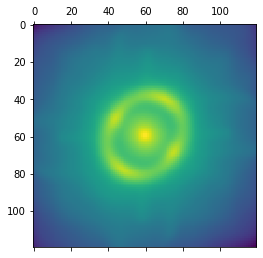

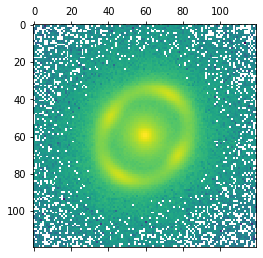

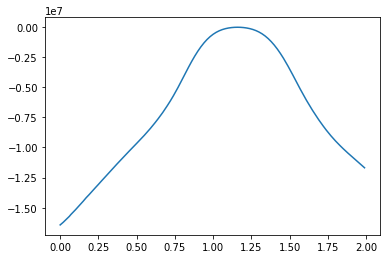

In [39]:
'''
In this part, we set the gaussian noise to zero, keeping only the poisson noise.
'''

background_rms = 0   # Set the gaussian noise variance to zero.
exp_time = 80       

# You can try different number of exp_time 
# to make the typical variance of the poisson noise be in the same order of the gaussian background
# that you can compare the likelihood for the two different noises.
# exp_time = 80 is a little bit large...


numPix = 120 
deltaPix = 0.05
fwhm = 0.1  
psf_type = 'PIXEL' 
kernel_size = 91

kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf = {'psf_type': psf_type, 'fwhm': fwhm, 'pixel_size': deltaPix, 'kernel_point_source': kernel_cut}
psf_class = PSF(**kwargs_psf)
kwargs_pemd = {'theta_E': 1.16, 'gamma': 1.95, 'center_x': 0.0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}
kwargs_lens = [kwargs_pemd, kwargs_shear, kwargs_nfw]
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light)
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
image_sim = image_sim + bkg + poisson
kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)


ThetaE_t3=np.zeros(200)
LogLikelihood_t3=np.zeros(200)


for i in range(200):
    thetaE=0.01*i
    kwargs_pemd = {'theta_E': thetaE, 'gamma': 1.95, 'center_x': 0.0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}
    kwargs_lens = [kwargs_pemd, kwargs_shear, kwargs_nfw]
    model_vary3 = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light)
    if i==100:
        plt.matshow(np.log10(model_vary3))
        plt.matshow(np.log10(data_class.data))
        plt.show()
    log_L=data_class.log_likelihood(model_vary3,mask)
    ThetaE_t3[i]=thetaE
    LogLikelihood_t3[i]=log_L
    
plt.plot(ThetaE_t3,LogLikelihood_t3)

- After finishing the above work, you can draw the above three curves together to observe them.. If you find the likelihood of poisson noise is much smaller than the gaussian one, you may really want to lower the exp_time in the above codes.

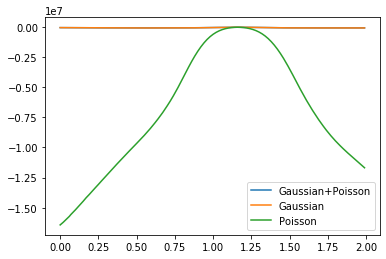

In [42]:
plt.plot(ThetaE_t1,LogLikelihood_t1,label='Gaussian+Poisson')
plt.plot(ThetaE_t2,LogLikelihood_t2,label='Gaussian')
plt.plot(ThetaE_t3,LogLikelihood_t3,label='Poisson')
plt.legend()
plt.show()

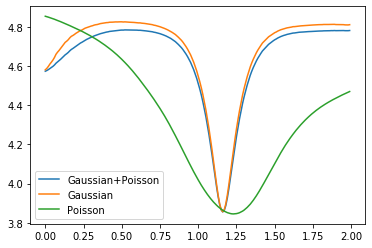

In [38]:
plt.plot(ThetaE_t1,np.log10(-LogLikelihood_t1),label='Gaussian+Poisson')
plt.plot(ThetaE_t2,np.log10(-LogLikelihood_t2),label='Gaussian')
plt.plot(ThetaE_t3,np.log10(-LogLikelihood_t3),label='Poisson')
plt.legend()
plt.show()

- After finishing all this things. We can modify the codes to find the likelihood function varies with some other parameters.